In [1]:
import torch as t
import numpy as np
import matplotlib
import pytorch_lightning as pl
import sys
sys.path.append("../ScaleableSEGNN")
from models.balanced_irreps import WeightBalancedIrreps
from train_sph import HSEGNN, O3HTransform, LitSPH
from e3nn.o3 import Irreps
from pytorch_lightning.tuner.tuning import Tuner

/home/hohausjs/miniconda3/envs/segnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'models'

In [ ]:
input_irreps = Irreps("2x1o + 3x0e")
output_irreps = Irreps("2x1o + 3x0e")
edge_attr_irreps = Irreps.spherical_harmonics(1)
node_attr_irreps = Irreps.spherical_harmonics(1)
additional_message_irreps = Irreps("3x0e")
additional_node_irreps = Irreps("1x0e")
additional_message_irreps_hl = Irreps("2x0e")
additional_message_irreps_il = Irreps("1x0e")

hidden_irreps = WeightBalancedIrreps(
            Irreps("{}x0e".format(32)), node_attr_irreps, sh=True, lmax=1)

lr = 0.05

model = LitSPH(HSEGNN, O3HTransform(1), lr, 1e-12, 
                input_irreps,
                hidden_irreps,
                output_irreps,
                edge_attr_irreps,
                node_attr_irreps,
                num_layers=1,
                num_ilayers=max(int(np.log2(int(1000)) / 3), 2),
                norm=None,
                task="node",
                additional_message_irreps=additional_message_irreps,
                additional_message_irreps_hl=additional_message_irreps_hl,
                additional_message_irreps_il=additional_message_irreps_il,
                additional_node_irreps=additional_node_irreps,
                shared_hweights=True,
                batch_size=2, neighbours=18,
                max_samples=40, dataset="", nballs=1000, target="pos", time_series=True,
                dsdir="/pfs/work7/workspace/scratch/tu_zxmye32-segnn/SPH/dataset/", dl_workers=4, load_mem=True)


In [ ]:
from pytorch_lightning.callbacks import DeviceStatsMonitor
trainer = pl.Trainer(precision=32, auto_lr_find=False, auto_scale_batch_size=False, enable_progress_bar=True, #profiler="simple", # log_every_n_steps=2, use_amp deterministic=True, 
    accelerator='gpu', devices=1, check_val_every_n_epoch=1, max_epochs=10,
    num_sanity_val_steps=3, callbacks=[DeviceStatsMonitor(cpu_stats=True)], default_root_dir=f"saved_models/_{1000}",
    gradient_clip_val=100, accumulate_grad_batches=4) #, StochasticWeightAveraging(swa_lrs=1e-2, swa_epoch_start=40)
tuner = Tuner(trainer)


In [ ]:
# Run learning rate finder
lr_finder = tuner.lr_find(model)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print(new_lr)

In [24]:
import torch as pt
import numpy as np
# lrs = pt.load("../lr_find_steps_27272.pt")
# lrs['lr']
base_lr = 1e-6
end_lr = 0.005
max_iter = 1000
# r = curr_iter / 1000
# newlr = base_lr * (end_lr / base_lr) ** r
new_lr = 0.00015
# curr_iter = 
np.log(new_lr/base_lr)/np.log(end_lr / base_lr) * max_iter

588.296541065436

suggested lr 1.2941958414499861e-06


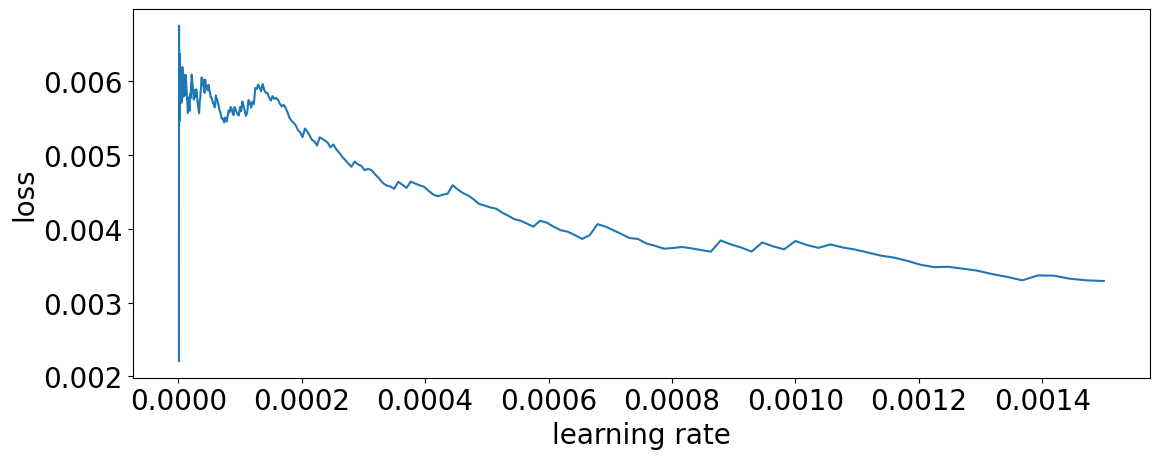

In [12]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
lrf = pt.load("../eval/lr_find_22511013.pt")
# lrf = pt.load("../eval/lr_find_22553750.pt")
# lrf = pt.load("../eval/lr_find_27399.pt")
sugg = lrf.suggestion(10)
print("suggested lr", sugg)
lr = np.array(lrf.results["lr"])
loss = np.array(lrf.results["loss"])

# lrf = pt.load("../lr_find_steps_27272.pt")
# lr = np.array(lrf["lr"])
# loss = np.array(lrf["loss"])
plt.figure(figsize=(12, 5))

mask = (lr <= 0.0015) #& (lr >= 0.00005)
plt.plot(lr[mask], loss[mask])
# grad = np.gradient(loss[mask])
# mg = (grad < 0) | (grad >= 0)
# plt.plot(lr[mask][mg], grad[mg], '.')
# plt.plot([np.min(lr[mask]), np.max(lr[mask])], [0,0])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.tight_layout()
plt.savefig("../eval/loss_lr.png")
# plt.vlines([sugg], [np.min(grad)], [np.max(grad)])#loss[mask])])